## 内容索引
1. 计算股票收益率----
diff做差分、std求标准差、where函数返回满足条件的数组索引

2. 日期分析例子----
载入文件对日期的处理、where和take函数、argmax和argmin函数

3. 周汇总例子----
apply_along_axis函数会调用一个自定义函数，作用于每一个数组元素上

4. 线性模型预测价格----
linalg.lstsq函数

5. 绘制趋势线例子----

6. ndarray补充----
clip函数，修剪；
compress函数，压缩；
prod函数，相乘；
cumprod函数，累积乘积。

上一小节，介绍了numpy中读取数据，计算均值方差，最大最小值等基本操作。这一节中，我将继续学习numpy常用函数，用来做更加深入的股票分析。
这里股票分析只是一个例子，不必在意概念细节，只是针对现有的数据来熟悉numpy的操作。

In [1]:
import numpy as np

## 1. 股票收益率

简单收益率是指相邻两个价格之间的变化率，而对数收益率是指所有价格取对数后两两之间的差值。由于对数收益率是两两价格相除再取对数，所以其**可以用来衡量价格收益率。**

投资者最感兴趣的是收益率的方差或标准差，这代表了投资风险的大小。

### 1.1 计算简单收益率
diff函数计算离散差分，计算收益率，需要用差值除以前一天的价格。

In [2]:
#cp means closing price
cp = np.loadtxt('data.csv', delimiter=',', usecols=(6,), unpack=True)
cp_diff = np.diff(cp)
rate_of_returns = cp_diff / cp[:-1]

In [3]:
cp

array([ 336.1 ,  339.32,  345.03,  344.32,  343.44,  346.5 ,  351.88,
        355.2 ,  358.16,  354.54,  356.85,  359.18,  359.9 ,  363.13,
        358.3 ,  350.56,  338.61,  342.62,  342.88,  348.16,  353.21,
        349.31,  352.12,  359.56,  360.  ,  355.36,  355.76,  352.47,
        346.67,  351.99])

In [4]:
#去掉最后一个，从开始到倒数第二个
cp[:-1]

array([ 336.1 ,  339.32,  345.03,  344.32,  343.44,  346.5 ,  351.88,
        355.2 ,  358.16,  354.54,  356.85,  359.18,  359.9 ,  363.13,
        358.3 ,  350.56,  338.61,  342.62,  342.88,  348.16,  353.21,
        349.31,  352.12,  359.56,  360.  ,  355.36,  355.76,  352.47,
        346.67])

In [5]:
rate_of_returns

array([ 0.00958048,  0.01682777, -0.00205779, -0.00255576,  0.00890985,
        0.0155267 ,  0.00943503,  0.00833333, -0.01010721,  0.00651548,
        0.00652935,  0.00200457,  0.00897472, -0.01330102, -0.02160201,
       -0.03408832,  0.01184253,  0.00075886,  0.01539897,  0.01450483,
       -0.01104159,  0.00804443,  0.02112916,  0.00122372, -0.01288889,
        0.00112562, -0.00924781, -0.0164553 ,  0.01534601])

In [6]:
print("standard deviation = ", np.std(rate_of_returns)) 

standard deviation =  0.0129221344368


### 1.2 对数收益率

取对数要注意事先检查数据中不包含0和负值，确保输入满足定义域条件

In [7]:
log_rate_of_returns = np.diff(np.log(cp))

In [8]:
log_rate_of_returns

array([ 0.00953488,  0.01668775, -0.00205991, -0.00255903,  0.00887039,
        0.01540739,  0.0093908 ,  0.0082988 , -0.01015864,  0.00649435,
        0.00650813,  0.00200256,  0.00893468, -0.01339027, -0.02183875,
       -0.03468287,  0.01177296,  0.00075857,  0.01528161,  0.01440064,
       -0.011103  ,  0.00801225,  0.02090904,  0.00122297, -0.01297267,
        0.00112499, -0.00929083, -0.01659219,  0.01522945])

得到收益率为正的情况，where函数可以根据制定条件返回数组的索引值

In [9]:
pos_return_indices = np.where(log_rate_of_returns > 0)
print('Indices with positive returns', pos_return_indices) 

Indices with positive returns (array([ 0,  1,  4,  5,  6,  7,  9, 10, 11, 12, 16, 17, 18, 19, 21, 22, 23,
       25, 28], dtype=int64),)


### 1.3 计算波动率
波动率volatility是对价格变动的一种度量。**年波动率等于对数收益率的标准差除以其均值，在除以交易日倒数的平方根，通常交易日取252天。**

In [10]:
annual_volatility = np.std(log_rate_of_returns) / np.mean(log_rate_of_returns)
annual_volatility = annual_volatility / np.sqrt(1. / 252.)
print(annual_volatility) 

129.274789911


sqrt函数中的除法运算必须使用浮点数才能得到正确结果。

In [11]:
print("Monthly volatility", annual_volatility * np.sqrt(1. / 12.)) 

Monthly volatility 37.3184173773


## 2. 日期分析
我们读入收盘价数据，根据星期几来切分数据，计算平均价格，最后找出一周的那一天的平均收盘价最高

**Numpy是面向浮点数运算的，对日期处理需要专门的方法**

loadtxt函数中有一个特定的参数converters，这是数据列到转换函数之间映射的字典。

In [15]:
#convert funtion
import datetime
def datestr2num(s):
    return datetime.datetime.strptime(s.decode("utf-8"), "%d-%m-%Y").date().weekday()

#字符串首先会按照指定形式"%d-%m-%Y"转换成一个datetime对象，随后datetime对象被转换成date对象，最后调用weekday方法返回一个数字
#0代表星期一，6代表星期天

In [16]:
#cp means closing price
dates, cp = np.loadtxt('data.csv', delimiter=',', usecols=(1,6), converters={1:datestr2num}, unpack=True)
print("Dates = ", dates) 

Dates =  [ 4.  0.  1.  2.  3.  4.  0.  1.  2.  3.  4.  0.  1.  2.  3.  4.  1.  2.
  3.  4.  0.  1.  2.  3.  4.  0.  1.  2.  3.  4.]


In [17]:
#保存各工作日的平均收盘价
averages = np.zeros(5)

**where函数会根据指定的条件返回所有满足条件的数组元素的索引值；take函数根据这些索引值从数组中取出相应的元素。**

In [19]:
for i in range(5):
    indices = np.where(dates == i)
    prices = np.take(cp, indices)
    avg = prices.mean()
    print("Day", i, "prices", prices, "Average", avg) 
    averages[i] = avg

Day 0 prices [[ 339.32  351.88  359.18  353.21  355.36]] Average 351.79
Day 1 prices [[ 345.03  355.2   359.9   338.61  349.31  355.76]] Average 350.635
Day 2 prices [[ 344.32  358.16  363.13  342.62  352.12  352.47]] Average 352.136666667
Day 3 prices [[ 343.44  354.54  358.3   342.88  359.56  346.67]] Average 350.898333333
Day 4 prices [[ 336.1   346.5   356.85  350.56  348.16  360.    351.99]] Average 350.022857143


In [20]:
#找出哪个工作日的平均收盘价最高，哪个最低
top = averages.max()
bottom = averages.min()
print("Highest average", top) 
print("Top day of the week", np.argmax(averages)) 
print("Lowest average", bottom) 
print("Bottom day of the week", np.argmin(averages)) 

Highest average 352.136666667
Top day of the week 2
Lowest average 350.022857143
Bottom day of the week 4


**argmin函数返回的是averages数组中最小元素的索引值，argmax同理**

## 3. 周汇总

In [21]:
dates, op, hp, lp, cp = np.loadtxt('data.csv', delimiter=',', usecols=(1,3,4,5,6), converters={1: datestr2num}, unpack=True)
cp = cp[:16]
dates = dates[:16]
#找到第一个星期一
first_monday = np.ravel(np.where(dates == 0))[0]
print("The first Monday index is ",first_monday) 

The first Monday index is  1


In [22]:
#找到最后一个周五
last_friday = np.ravel(np.where(dates == 4))[-1]
print("The last Friday index is ", last_friday) 

The last Friday index is  15


In [23]:
#存储三周每一天的索引值
weeks_indices = np.arange(first_monday, last_friday+1)
print("Weeks indices initial ",weeks_indices) 

Weeks indices initial  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [24]:
#切分数组，每5个元素一个子数组
weeks_indices = np.split(weeks_indices, 3)
print("Weeks indices after split ", weeks_indices) 

Weeks indices after split  [array([1, 2, 3, 4, 5], dtype=int64), array([ 6,  7,  8,  9, 10], dtype=int64), array([11, 12, 13, 14, 15], dtype=int64)]


**apply_along_axis函数会调用一个自定义函数，作用于每一个数组元素上。**在调用apply_along_axis时提供我们自定义的函数summarize，并指定要作用的轴或维度的编号以及函数的参数

In [25]:
#这里indices是三个array
def summarize(indices, open, high, low, close):
    monday_open = open[indices[0]]
    week_high = np.max(np.take(high, indices))
    week_low = np.min(np.take(low, indices))
    friday_close = close[indices[-1]]
    return ("APPL", monday_open, week_high, week_low, friday_close)

In [26]:
#这里参数1，代表作用于每一行，一共三行，得到三行结果
#相当于axis为1的时候进行计算
week_summary = np.apply_along_axis(summarize, 1, weeks_indices, op, hp, lp, cp)
print("Week summary", week_summary) 

Week summary [['APPL' '335.8' '346.7' '334.3' '346.5']
 ['APPL' '347.8' '360.0' '347.6' '356.8']
 ['APPL' '356.7' '364.9' '349.5' '350.5']]


## 4. 用线性模型预测价格
NumPy的linalg包是专门用于线性代数计算的，我们可以根据N个之前的价格利用线性模型进行预测计算。

 我们假设，一个股价可以用之前股价的线性组合表示出来，即，这个股价等于之前股价的加权和的结果。用线性代数的角度，这是解一个最小二乘法的问题。

In [27]:
#1. 获得N个股价的向量b
cp = np.loadtxt('data.csv', delimiter=',', usecols=(6,), unpack=True)
N = 5
#从倒数第N个数据取到最后
b = cp[-N:]
print(b) 
#翻转数组，越前面数据，日期越新
b = b[::-1]
print(b)

[ 355.36  355.76  352.47  346.67  351.99]
[ 351.99  346.67  352.47  355.76  355.36]


In [28]:
#2. 初始N*N的二维数组A
A = np.zeros((N,N), float)
print("Zeros N by N\n", A) 

Zeros N by N
 [[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


In [29]:
#3. 用b向量的N个股价值填充数组A
for i in range(N):
    A[i,] = cp[-N-1-i : -1-i]
    
print("A:\n", A) 

A:
 [[ 360.    355.36  355.76  352.47  346.67]
 [ 359.56  360.    355.36  355.76  352.47]
 [ 352.12  359.56  360.    355.36  355.76]
 [ 349.31  352.12  359.56  360.    355.36]
 [ 353.21  349.31  352.12  359.56  360.  ]]


In [30]:
#4. 使用linalg中的lstsq来解决最小平方和的问题
(x, residuals, rank, s) = np.linalg.lstsq(A, b)
print('x:\n', x) 
print('residuals:\n', residuals) 
print('rank:\n', rank) 
print('s:\n', s) 

x:
 [ 0.78111069 -1.44411737  1.63563225 -0.89905126  0.92009049]
residuals:
 []
rank:
 5
s:
 [  1.77736601e+03   1.49622969e+01   8.75528492e+00   5.15099261e+00
   1.75199608e+00]


**返回的元组中包含稍后要用到的系数向量x，一个残差数组，A的秩以及A的奇异值**

In [31]:
#5. 使用numpy中的dot函数计算系数向量与最近N个价格构成的向量的点积
print(np.dot(b, x)) 

357.939161015


## 5. 绘制趋势线
趋势线，是根据股价走势图上很多所谓的枢轴点绘成的曲线，即描绘的是价格变化的趋势。

In [32]:
%matplotlib inline
from matplotlib.pyplot import plot
from matplotlib.pyplot import show

In [33]:
#我们假设枢轴点的位置是最高价、最低价、收盘价的均值
hp, lp, cp = np.loadtxt('data.csv', delimiter=',', usecols=(4,5,6), unpack=True)
pivots = (hp+lp+cp) / 3
print("Pivots:\n", pivots) 

Pivots:
 [ 338.01        337.88666667  343.88666667  344.37333333  342.07666667
  345.57        350.92333333  354.29        357.34333333  354.18
  356.06333333  358.45666667  359.14        362.84333333  358.36333333
  353.19333333  340.57666667  341.95666667  342.13333333  347.13
  353.12666667  350.90333333  351.62333333  358.42333333  359.34666667
  356.11333333  355.13666667  352.61        347.11333333  349.77      ]


从枢轴点出发，我们可以推导出阻力位和支撑位。
> 阻力位是指股价上升时遇到阻力，在转秩前的最高价格

> 支撑位是股价下跌时遇到支撑，在反弹前的最低价格

他们都是估计量，根据这些估计量，我们可以绘制阻力位和支撑位的趋势线。

In [34]:
#定义直线方程为y = Ax，其中A=[t 1],x=[a b]
#展开就是y = at + b
def fit_line(t, y):
    #vstack垂直组合
    A = np.vstack([t, np.ones_like(t)]).T
    return np.linalg.lstsq(A, y)[0]

In [35]:
#假设支撑位在枢轴点下方的位置
#阻力点在枢轴点上方的一个位置
t = np.arange(len(cp))
sa, sb = fit_line(t, pivots-(hp-lp))
ra, rb = fit_line(t, pivots+(hp-lp))
support = sa*t + sb
resistance = ra*t + rb

In [36]:
#设置一个判断数据点是否在趋势线之间的条件
condition = (cp > support) & (cp < resistance)
print("Conditions:\n", condition) 
between_bands = np.where(condition)
print(between_bands) 
print(np.ravel(between_bands)) 

Conditions:
 [False False  True  True  True  True  True False False  True False False
 False False False  True False False False  True  True  True  True False
 False  True  True  True False  True]
(array([ 2,  3,  4,  5,  6,  9, 15, 19, 20, 21, 22, 25, 26, 27, 29], dtype=int64),)
[ 2  3  4  5  6  9 15 19 20 21 22 25 26 27 29]


In [37]:
#复查取值
print(support[between_bands]) 
print(cp[between_bands]) 
print(resistance[between_bands]) 

[ 341.92421382  342.19081893  342.45742405  342.72402917  342.99063429
  343.79044964  345.39008034  346.4565008   346.72310592  346.98971104
  347.25631615  348.0561315   348.32273662  348.58934174  349.12255197]
[ 345.03  344.32  343.44  346.5   351.88  354.54  350.56  348.16  353.21
  349.31  352.12  355.36  355.76  352.47  351.99]
[ 352.61688271  352.90732765  353.19777259  353.48821753  353.77866246
  354.64999728  356.39266691  357.55444667  357.84489161  358.13533655
  358.42578149  359.2971163   359.58756124  359.87800618  360.45889606]


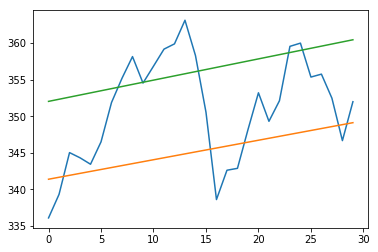

In [38]:
plot(t, cp)
plot(t, support)
plot(t, resistance)

In [39]:
n_betweens_band = len(np.ravel(between_bands))
print("Number points between bands: ", n_betweens_band) 
print("Ratio between bands: ", float(n_betweens_band)/len(cp)) 

Number points between bands:  15
Ratio between bands:  0.5


In [40]:
#提供另外一种计算支撑位和阻力位之间数据点个数的方法
# []操作符定义选择条件
# intersect1d计算两者相交的结果
a1 = cp[cp > support]
a2 = cp[cp < resistance]
print("Number of points between band2 2nd approach: ", len(np.intersect1d(a1, a2))) 

Number of points between band2 2nd approach:  15


## 补充： ndarray对象的几种方法
> clip，修剪

> compress，压缩

> prod，相乘

> cumprod，累积乘积

In [41]:
#clip方法
#将所有比给定最大值还大的元素全部设为给定最大值
#将所有比给定最小值还小的元素全部设为最小值
a = np.arange(5)
print("a = ",a) 
print("Clipped:", a.clip(1,3)) 

a =  [0 1 2 3 4]
Clipped: [1 1 2 3 3]


In [42]:
#compress方法
#返回一个根据给定条件筛选后的数组
a = np.arange(5)
print(a) 
print("Compressed: ", a.compress(a > 2)) 

[0 1 2 3 4]
Compressed:  [3 4]


In [43]:
# prod方法计算数组中所有元素的乘积
# 这种方法可以计算阶乘 factorial
b = np.arange(1,6)
print("b = ", b)  
print("factorial: ", b.prod()) 

b =  [1 2 3 4 5]
factorial:  120


In [44]:
# cumprod方法，计算数组元素的累积乘积
print("factorials array: ", b.cumprod()) 

factorials array:  [  1   2   6  24 120]
